# Titanic - Machine Learning from Disaster

## Import thư viện

In [ ]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

## Load dữ liệu

In [350]:
# Load data 
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

## Preview data

In [351]:
print('Loaded:', train_df.shape, test_df.shape)
train_df.head()

Loaded: (891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [352]:
test_df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


- `PassengerId`: Mã khách hàng
- `Survived`: Trạng thái sống sót
- `Pclass`: Hạng vé
- `Name`: Họ tên khách hàng
- `Sex`: Giới tính
- `Cabin`: Số Cabin
- `Age`: Độ tuổi
- `SibSp`: Số lượng anh/chị/em hoặc vợ chồng đi cùng
- `Parch`: Số lượng cha/mẹ hoặc con đi cùng
- `Ticket`: Số vé
- `Fare`: Giá vé
- `Embarked`: Nơi lên tàu

## Exploratory Data Analysis - EDA

In [353]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [354]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [355]:
def display_missing_data(df):
    missing = df.isna().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    percent = (missing / len(df)) * 100
    print(pd.DataFrame({'Missing Values': missing, 'Percent (%)': percent.round(2)}))

display_missing_data(train_df)

          Missing Values  Percent (%)
Cabin                687        77.10
Age                  177        19.87
Embarked               2         0.22


In [356]:
display_missing_data(test_df)

       Missing Values  Percent (%)
Cabin             327        78.23
Age                86        20.57
Fare                1         0.24


In [357]:
def best_features_for_imputation(df, target='Age', top=10):
    """
    Phân tích mối tương quan giữa 1 feature (vd: Age)
    với tất cả các feature khác trong dataframe để gợi ý 
    nên dùng cột nào để điền missing values.
    """
    corrs = {}
    for col in df.columns:
        if col == target:
            continue

        try:
            # Nếu là numeric -> dùng Spearman correlation
            if np.issubdtype(df[col].dropna().dtype, np.number):
                corr = spearmanr(df[target], df[col], nan_policy='omit')[0]
            else:
                # Nếu là object -> factorize (chuyển sang mã số)
                corr = spearmanr(df[target], pd.factorize(df[col])[0], nan_policy='omit')[0]
            corrs[col] = abs(corr)
        except Exception as e:
            continue

    # Sắp xếp giảm dần
    corrs_sorted = pd.Series(corrs).sort_values(ascending=False)
    result = corrs_sorted.head(top).to_frame('Spearman Corr (|r|)')
    print(f"\nTop {top} features liên quan mạnh nhất đến '{target}':\n")
    print(result)

    # --- Vẽ heatmap ---
    plt.figure(figsize=(8, max(4, top * 0.3)))
    sns.heatmap(result.T, annot=True, cmap='YlGnBu', fmt=".2f", cbar=False)
    plt.title(f"Top Correlations with {target}", fontsize=13)
    plt.xlabel("Features")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Target Variable: `Survived`

In [358]:
survival_counts = train_df['Survived'].value_counts(normalize=True)

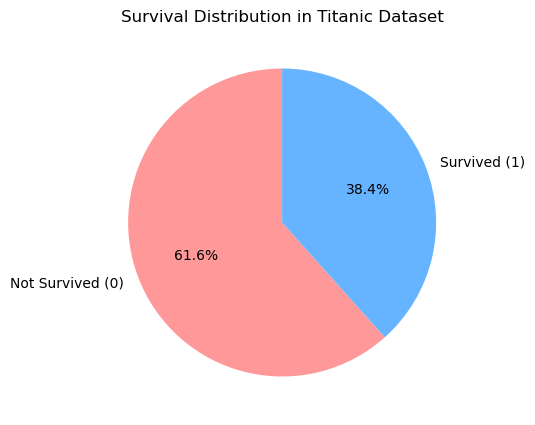

In [359]:
plt.figure(figsize=(5,5))
plt.pie(
    survival_counts,
    labels=['Not Survived (0)', 'Survived (1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999','#66b3ff']
)
plt.title('Survival Distribution in Titanic Dataset')
plt.show()

Chỉ có khoảng 38.4% hành khách sống sót trong thảm họa Titanic.

- Phân bố của các Features

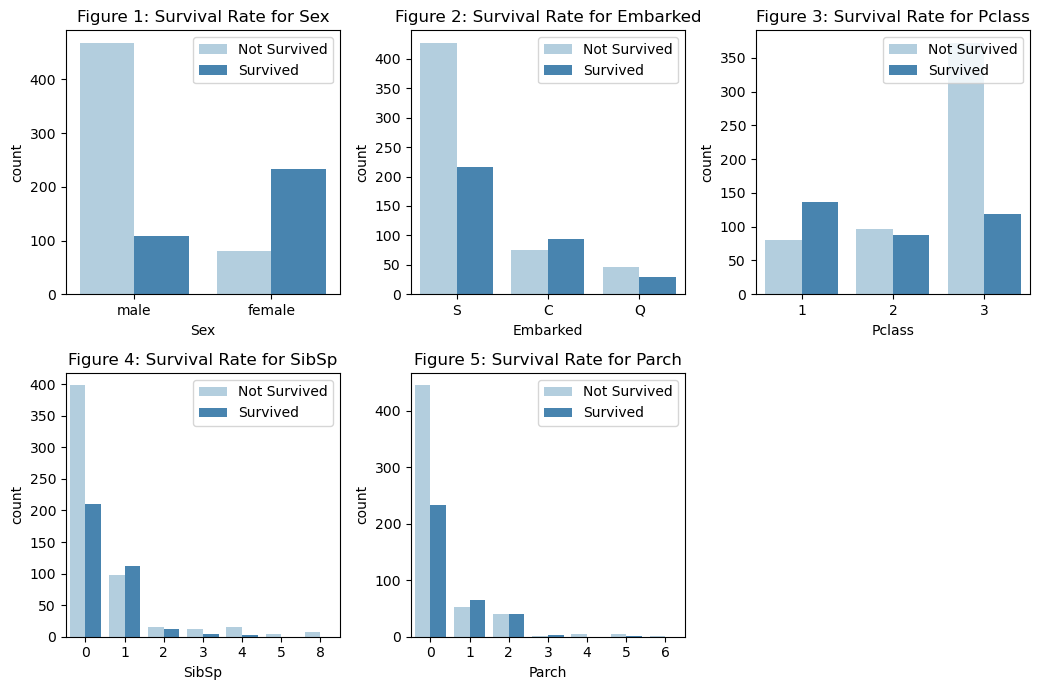

In [360]:
cols = [ 'Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch'] 

n_rows = 2
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c
        if i < len(cols):
            ax_i = ax[r,c]
            sns.countplot(data=train_df, x=cols[i], hue='Survived', palette='Blues', ax=ax_i)
            ax_i.set_title(f'Figure {i+1}: Survival Rate for {cols[i]}')
            ax_i.legend(title='', loc='upper right', labels=['Not Survived', 'Survived'])
ax.flat[-1].set_visible(False)
plt.tight_layout()

**Tỉ lệ sống sót**:
- Fig 1: Tỉ lệ sống sót của nữ giới cao hơn nam giới.
- Fig 2: Đa phần mọi người đi đến Southampton, và cũng có lượng người không sống sót cao nhất.
- Fig 3: Vé hạng 1 có tỉ lệ sống sót cao hơn.
- Fig 4: Những người với `SibSp` bằng 0 hầu hết sẽ không sống sót, số lượng hành khách đi với 1-2 thành viên gia đình có cơ hội sống sót cao hơn.
- Fig 5: Những người với `Parch` bằng 0 đa phần sẽ không sống sót, số lượng hành khách đi với 1-2 thành viên gia đình có cơ hội sống sót cao hơn.

- Age

<Axes: xlabel='Age', ylabel='Count'>

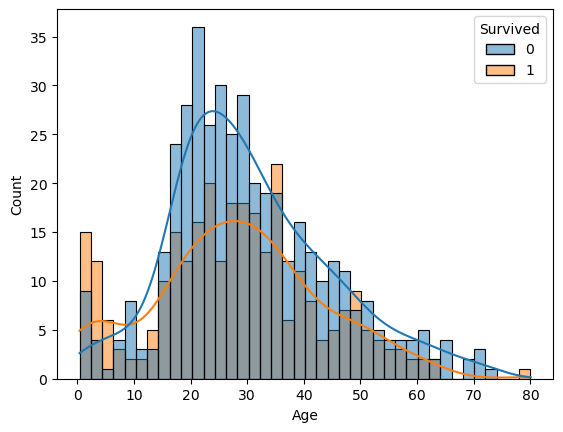

In [361]:
sns.histplot(data=train_df, x='Age', hue='Survived', bins=40, kde=True)

- Đa phần hành khách có độ tuổi từ 18-40 tuổi.
- Trẻ em có nhiều cơ hội sống sót hơn những độ tuổi khác

- Fare

<Axes: xlabel='Fare', ylabel='Count'>

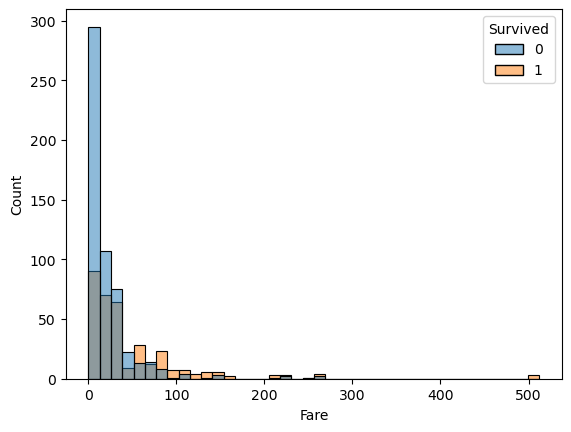

In [362]:
sns.histplot(data=train_df, x='Fare', hue='Survived', bins=40)

- Phần lớn hành khách có giá vé rất thấp, chủ yếu nằm trong khoảng 0 – 50.
- Ở mức giá vé thấp, phần lớn hành khách không sống sót.
- Ở mức giá vé cao hơn (>50), tỉ lệ hành khách sống sót cao hơn rõ rệt.
- Hành khách hạng cao thường ở các khoang dễ tiếp cận xuồng cứu sinh.

- SibSp và Parch

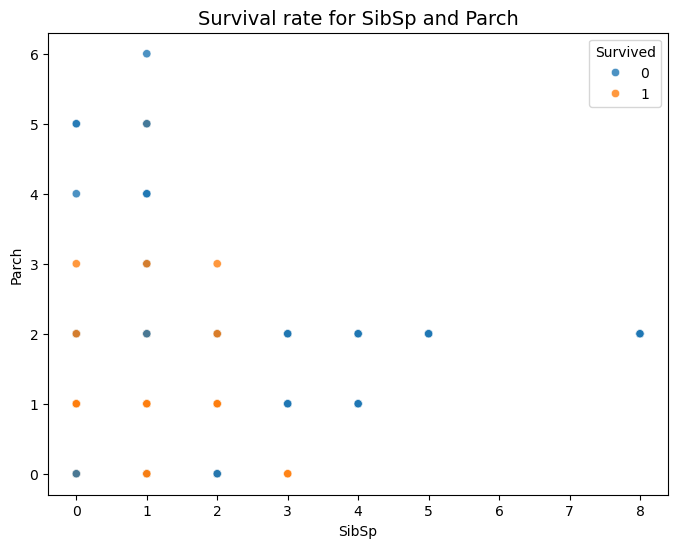

In [363]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=train_df,
    x='SibSp',
    y='Parch',
    hue='Survived',
    alpha=0.8
)
plt.title('Survival rate for SibSp and Parch', fontsize=14)
plt.xlabel('SibSp')
plt.ylabel('Parch')
plt.legend(title='Survived')
plt.show()

- Phần lớn hành khách đi một mình (SibSp=0, Parch=0) → ít sống sót.
- Hành khách đi cùng gia đình nhỏ (1–2 người thân) → tỉ lệ sống sót cao hơn.
- Gia đình đông (≥3 người) hầu hết không sống sót.

- Fare và Pclass

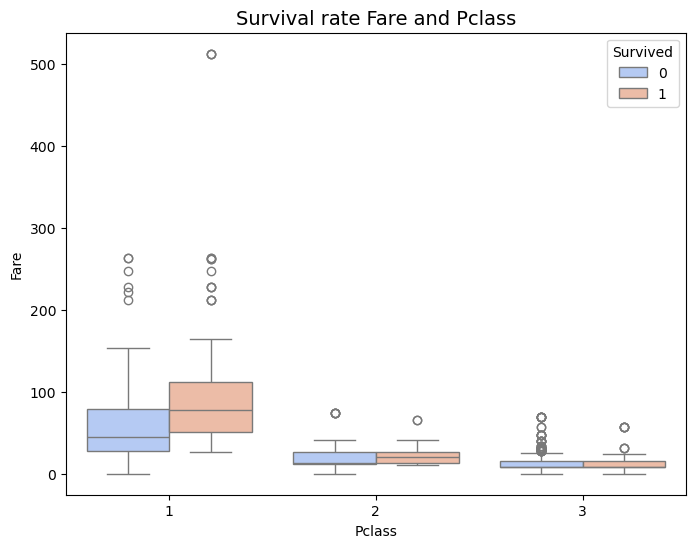

In [364]:
plt.figure(figsize=(8,6))
sns.boxplot(data=train_df, x='Pclass', y='Fare', hue='Survived', palette='coolwarm')
plt.title('Survival rate Fare and Pclass', fontsize=14)
plt.xlabel('Pclass')
plt.ylabel('Fare')
plt.legend(title='Survived')
plt.show()

- Hành khách hạng 1 có giá vé cao nhất và tỉ lệ sống sót lớn hơn rõ rệt.
- Hạng 3 có giá vé thấp nhất, đa phần không sống sót.
- Trong mỗi hạng vé, người trả giá vé cao hơn có xu hướng sống sót cao hơn.


Top 20 features liên quan mạnh nhất đến 'Survived':

             Spearman Corr (|r|)
Sex                     0.543351
Pclass                  0.339668
Fare                    0.323736
Cabin                   0.316508
Parch                   0.138266
Embarked                0.130585
SibSp                   0.088879
Age                     0.052565
Ticket                  0.039201
PassengerId             0.005007
Name                    0.005007


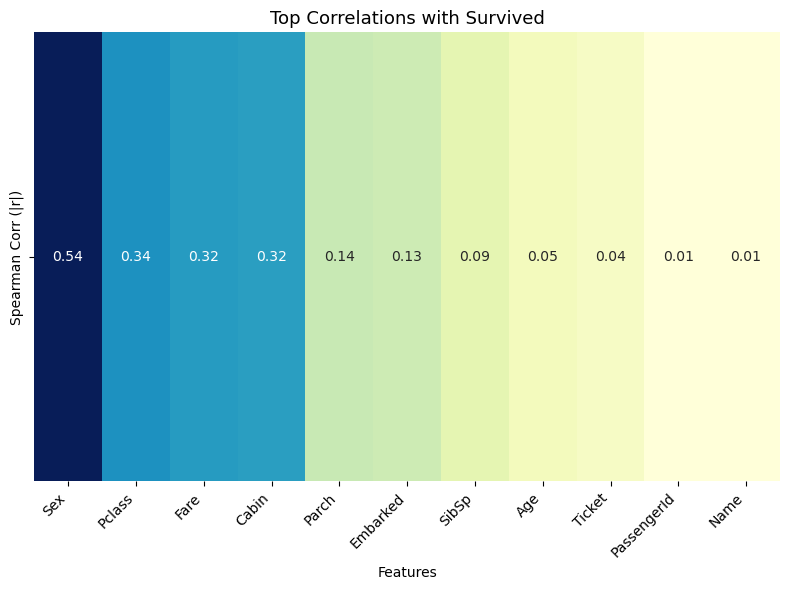

In [365]:
best_features_for_imputation(train_df, target='Survived', top=20)

**Ta có các biến liên quan đến `Survived` và không bị missing:**
- Sex
- Pclass
- SibSp / Parch
- Name

## Feature Engineering (Các features không bị missing)

#### Tạo thêm các biến mới giúp mô hình phân tích chuẩn xác và mạnh hơn

- `Title` (tách ra từ Name): Phản ánh giới tính, địa vị, tầng lớp xã hội.
- `FamilySize` (gộp lại từ `SibSp` và `Parch`): Quy mô gia đình ảnh hưởng tỉ lệ sống, đi cùng thành viên gia đình có tỉ lệ sống sót cao hơn.
- `IsChild`: Đánh dấu trẻ em (dưới 12 tuổi). Trong Titanic, trẻ em thường được cứu trước theo nguyên tắc “women and children first”.
- `IsMother`: Đánh dấu phụ nữ trưởng thành có con đi cùng. Mẹ thường được ưu tiên cứu cùng con.

In [366]:
# Feature engineering
def extract_title(name):
    m = re.search(r',\s*([^\.]+)\.', name)
    return m.group(1).strip() if m else ''

title_map = {
    'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer', 'Dr': 'Officer', 'Rev': 'Officer',
    'Don': 'Royalty', 'Sir': 'Royalty', 'Lady': 'Royalty', 'the Countess': 'Royalty', 'Jonkheer': 'Royalty', 'Dona': 'Royalty'
}

for df in [train_df, test_df]:
    # --- Title (Name) ---
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss')
    df['Title'] = df['Title'].replace(['Mme'],'Mrs')
    df['Title'] = df['Title'].replace(title_map)
    rare = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
    df['Title'] = df['Title'].replace(list(rare), 'Other')

    # --- Family (SibSp/Parch) ---
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # --- Special groups ---
    df['IsChild'] = (df['Age'] < 12).astype(int)
    df['IsMother'] = ((df['Sex'] == 'female') & (df['Parch'] > 0) & (df['Age'] > 18) & (df['Title'] == 'Mrs')).astype(int)

## Filling missing values

In [367]:
display_missing_data(train_df)

          Missing Values  Percent (%)
Cabin                687        77.10
Age                  177        19.87
Embarked               2         0.22


- Trong file train.csv, chỉ có 2 giá trị bị thiếu (NaN) trên tổng 891 dòng —
tức là 0.2% dữ liệu → rất ít, không ảnh hưởng lớn đến phân phối.
- Chọn mode() là giá trị xuất hiện nhiều nhất trong cột để điền "giá trị đại diện" cho `Embarked`.

In [368]:
display_missing_data(test_df)

       Missing Values  Percent (%)
Cabin             327        78.23
Age                86        20.57
Fare                1         0.24


- Fare chỉ thiếu 1 giá trị → nên điền theo median. Median (trung vị) phản ánh mức trung tâm thực tế hơn cho dữ liệu lệch, vì nó không bị ảnh hưởng bởi các giá trị cực trị.


Top 10 features liên quan mạnh nhất đến 'Fare':

            Spearman Corr (|r|)
Pclass                 0.688032
Cabin                  0.532923
FamilySize             0.528907
SibSp                  0.447113
Parch                  0.410074
Survived               0.323736
Title                  0.303792
Sex                    0.259593
Ticket                 0.258902
IsMother               0.183694


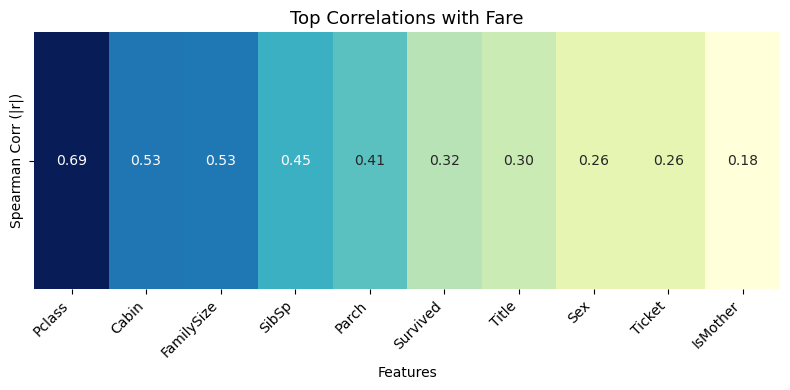

In [369]:
best_features_for_imputation(train_df, target='Fare', top=10)

- Ta thấy Pclass liên quan mạnh nhất đến `Fare` nên điền missing value của `Fare` bằng median trong từng nhóm Pclass.

Qua phân tích, ta nhận thấy một số đặc trưng có mối quan hệ chặt chẽ với `Age`:
- `Pclass`: Hạng vé, đại diện cho tầng lớp xã hội – hành khách ở hạng cao (Pclass=1) thường lớn tuổi hơn.
- `Title` (Mr, Miss, Dr, Master...): Phản ánh rõ độ tuổi và vai trò xã hội.
- `Sex`: Giới tính ảnh hưởng đến độ tuổi trung bình trong từng tầng lớp xã hội.
khi điền các giá trị thiếu của Age, việc nhóm theo `Sex + Pclass + Title` là lựa chọn tối ưu, giúp ước lượng tuổi gần sát thực tế và duy trì mối quan hệ tự nhiên giữa các đặc trưng.

In [370]:
# Fill missing values
for df in [train_df, test_df]:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
    df['Age'] = df.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))

    # --- Chuẩn hóa log ---
    df['Fare'] = np.log1p(df['Fare'])
    df['Age'] = np.log1p(df['Age'])

Việc chuẩn hóa log giúp giảm độ lệch, ổn định mô hình, và giảm ảnh hưởng của các giá trị cực lớn trong `Fare` và `Age`.

## Feature Engineering (Các biến khác)

In [371]:
for df in [train_df, test_df]:

    df['HasCabin'] = df['Cabin'].notna().astype(int)

    df['Age*Pclass'] = df['Age'] * df['Pclass']

    # --- Cabin / Deck ---
    df['Deck'] = df['Cabin'].astype(str).str[0]
    df['Deck'] = df['Deck'].replace('n', 'U')  # 'U' = Unknown

    # --- Interaction features ---
    df['Fare_Pclass'] = df['Fare'] / df['Pclass']

    df['TicketPrefix'] = df['Ticket'].apply(lambda x: re.split(r'\s|\.', str(x))[0])
    df['TicketPrefix'] = df['TicketPrefix'].apply(lambda x: x if x.isalpha() else 'NUM')

- `HasCabin`: Có Cabin hay không. Người có cabin → hạng vé cao → tầng lớp giàu có.
- `Deck`: Boong tàu – ký tự đầu của Cabin (A, B, C, D...). Deck thấp → gần đáy tàu → nguy hiểm hơn.
- `Age*Pclass`: Kết hợp tuổi và hạng vé – phản ánh tầng lớp xã hội theo tuổi.
- `Fare_Pclass`: Giá vé chia theo hạng vé.
- `TicketPrefix`: Phần đầu của mã vé cho biết hãng tàu hoặc loại vé.

### Các features để mô hình phân tích

In [372]:
# Prepare features
feature_cols = [
    'Pclass','Sex','Age','Fare','Embarked','Title','FamilySize','IsChild','IsMother',
    'Deck','HasCabin','Fare_Pclass','Age*Pclass','TicketPrefix'
]
x = train_df[feature_cols]
y = train_df['Survived']
x_test_final = test_df[feature_cols]

- Đoạn code trên chọn ra các biến đầu vào quan trọng nhất sau khi xử lý dữ liệu và tạo feature mới.
- Tập dữ liệu x chứa các đặc trưng này, trong khi y là biến mục tiêu `Survived`.
- Tập x_test_final được chuẩn bị tương tự để dự đoán kết quả cuối cùng.

### Preprocess pipeline

In [373]:
# Preprocessor (ColumnTransformer)
num_features = [
    'Age','Fare','FamilySize','Fare_Pclass','Age*Pclass'
]
cat_features = [
    'Pclass','Sex','Embarked','Title','IsChild','IsMother',
    'Deck','HasCabin','TicketPrefix'
]

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_transformer, num_features), ('cat', cat_transformer, cat_features)])

- `num_features`: Các biến số cần được chuẩn hóa (StandardScaler) để tránh chênh lệch thang đo.
- `cat_features`: Các biến phân loại (category) cần được mã hóa (OneHotEncoder) để mô hình có thể hiểu được.
- Biến số: điền điền median → chuẩn hóa thang đo.
- Biến phân loại: điền giá trị phổ biến nhất → one-hot encoding.

Dùng `ColumnTransformer` để gộp tất cả trong một bước, giúp mô hình hóa dễ dàng và nhất quán.

## Models Training

**Các mô hình dùng để phân tích**: `Logistic Regression`, `Random Forest`, `XGBoost`, `SVM`

Định nghĩa các pipeline mô hình học máy (dùng chung preprocessor, khác models)
- `Logistic Regression`: mô hình tuyến tính cơ bản (baseline)
- `Random Forest`: tập hợp nhiều cây quyết định, giúp giảm overfitting
- `XGBoost`: mô hình boosting mạnh mẽ, cho hiệu suất cao nhất
- `SVM`: bộ phân loại phi tuyến, phù hợp với ranh giới phức tạp

In [374]:
# --- Khởi tạo các pipeline ---
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000,random_state=42,C=1.0,solver='lbfgs'))
    ]),

    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=500, max_depth=5,min_samples_split=5, min_samples_leaf=3))
    ]),

    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(random_state=42,eval_metric='logloss',n_jobs=-1,n_estimators=120,max_depth=2,learning_rate=0.08,subsample=0.6,colsample_bytree=0.6,reg_lambda=3,reg_alpha=2))
    ]),

    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
    ])
}

- Mỗi mô hình đều kết hợp với cùng bộ xử lý dữ liệu (preprocessor) để đảm bảo đầu vào nhất quán.
- Lưu trong dictionary models giúp dễ huấn luyện và so sánh kết quả giữa các thuật toán.

### Đánh giá từng model bằng cross-validation

In [375]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {'Model': [], 'Metric': [], 'Score': []}

for name, model in models.items():
    acc_scores = cross_val_score(model, x, y, cv=cv, scoring='accuracy')
    f1_scores  = cross_val_score(model, x, y, cv=cv, scoring='f1')
    auc_scores = cross_val_score(model, x, y, cv=cv, scoring='roc_auc')

    # Lưu chi tiết từng lần CV
    for s in acc_scores:
        results['Model'].append(name)
        results['Metric'].append('Accuracy')
        results['Score'].append(s)
    for s in f1_scores:
        results['Model'].append(name)
        results['Metric'].append('F1 Score')
        results['Score'].append(s)
    for s in auc_scores:
        results['Model'].append(name)
        results['Metric'].append('ROC AUC')
        results['Score'].append(s)

    # Tính trung bình và độ lệch chuẩn
    acc_mean, acc_std = acc_scores.mean(), acc_scores.std()
    f1_mean, f1_std = f1_scores.mean(), f1_scores.std()
    auc_mean, auc_std = auc_scores.mean(), auc_scores.std()

    print(f"{name} CV Results:")
    print(f"  Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
    print(f"  ROC AUC:  {auc_mean:.4f} ± {auc_std:.4f}")
    print("-" * 40)

Logistic Regression CV Results:
  Accuracy: 0.8192 ± 0.0338
  F1 Score: 0.7568 ± 0.0479
  ROC AUC:  0.8750 ± 0.0377
----------------------------------------
Random Forest CV Results:
  Accuracy: 0.8271 ± 0.0321
  F1 Score: 0.7529 ± 0.0557
  ROC AUC:  0.8710 ± 0.0459
----------------------------------------
XGBoost CV Results:
  Accuracy: 0.8159 ± 0.0365
  F1 Score: 0.7477 ± 0.0587
  ROC AUC:  nan ± nan
----------------------------------------
SVM CV Results:
  Accuracy: 0.8350 ± 0.0227
  F1 Score: 0.7652 ± 0.0406
  ROC AUC:  0.8727 ± 0.0339
----------------------------------------


- Sử dụng StratifiedKFold (10-fold CV) để đánh giá 4 mô hình khác nhau.
- Tính 3 chỉ số: Accuracy, F1 Score, ROC AUC cho từng mô hình.
- Lưu và in kết quả trung bình ± độ lệch chuẩn để so sánh hiệu suất và độ ổn định giữa các mô hình.

### Đánh giá từng model bằng hàm train_test_split

In [ ]:
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
# for name, model in models.items():
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_val)
#     y_prob = model.predict_proba(x_val)[:,1]

#     acc = accuracy_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)
#     auc = roc_auc_score(y_val, y_prob)

#     print(f"{name} Results:")
#     print(f"  Accuracy: {acc:.4f}")
#     print(f"  F1 Score: {f1:.4f}")
#     print(f"  ROC AUC:  {auc:.4f}")
#     print("-" * 35)

Logistic Regression Results:
  Accuracy: 0.8156
  F1 Score: 0.7724
  ROC AUC:  0.8880
-----------------------------------
Random Forest Results:
  Accuracy: 0.8101
  F1 Score: 0.7536
  ROC AUC:  0.9001
-----------------------------------
XGBoost Results:
  Accuracy: 0.8156
  F1 Score: 0.7755
  ROC AUC:  0.8932
-----------------------------------
SVM Results:
  Accuracy: 0.8212
  F1 Score: 0.7746
  ROC AUC:  0.8656
-----------------------------------


- Chia dữ liệu thành train (80%) và validation (20%).
- Huấn luyện từng mô hình, dự đoán kết quả trên tập validation.
- Đánh giá bằng Accuracy, F1 Score, ROC AUC để so sánh hiệu năng.

### Chọn mô hình tốt nhất

In [377]:
best_model = models['SVM']
best_model.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


- Chọn SVM làm mô hình tốt nhất từ danh sách models.
- Huấn luyện lại mô hình này trên toàn bộ tập dữ liệu huấn luyện (x, y) để tối ưu hiệu năng trước khi dự đoán trên tập test.

## Xuất ra file kết quả

In [378]:
# Prepare submission (predict on test)
try:
    preds = best_model.predict(x_test_final)
    submission = pd.DataFrame({
        'PassengerId': test_df['PassengerId'], 
        'Survived': preds.astype(int)
    })
    submission.to_csv('submission.csv', index=False)
    print("File 'submission.csv' created.")
except Exception as e:
    print('Không thể tạo submission tự động:', e)


File 'submission.csv' created.


- Dùng mô hình tốt nhất (best_model) để dự đoán Survived cho tập test.
- Tạo DataFrame chứa PassengerId và Survived.
- Xuất kết quả ra file submission.csv theo định dạng chuẩn Kaggle.

In [ ]:
# !jupyter nbconvert --to script Titanic_Code.ipynb

# Kết thúc